In [1]:
from run_on_video.run import QDDETRPredictor
from IPython.display import display, Image
import ffmpeg, tempfile

In [22]:
def overlaps(t1, t2):
    return t1[0] <= t2[0] <= t1[1] or t1[0] <= t2[1] <= t1[1] or t2[0] <= t1[0] <= t2[1] or t2[0] <= t1[1] <= t2[1]

def overlaps_with_accepted(filtered, highlight):
    for accepted in filtered:
        if overlaps(highlight, accepted):
            return True

    return False

def filter_overlaps(highlights):
    if not highlights:
        return []
    highlights.sort(key=lambda x: x[2], reverse=True)
    filtered = []
    for highlight in highlights:
        if overlaps_with_accepted(filtered, highlight):
            continue
        filtered.append(highlight)

    return filtered

In [23]:
video_path = "sziget/selfie_day.mp4"
queries = ["Visually pleasing and exciting moments for festival after-movie."]

In [24]:
# run predictions
print("Build models...")
qd_detr_predictor = QDDETRPredictor(
    ckpt_path="run_on_video/qd_detr_ckpt/model_best.ckpt",
    clip_model_name_or_path="ViT-B/32",
    device="cuda"
)
predictions = qd_detr_predictor.localize_moment(video_path=video_path, query_list=queries)

Build models...
Loading feature extractors...
Loading CLIP models


/home/isedlak/.conda/envs/test/lib/python3.10/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Loading trained QD-DETR model...


/home/isedlak/projects/QD-DETR/qd_detr/position_encoding.py:67: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
/home/isedlak/projects/QD-DETR/qd_detr/transformer.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = 10000 ** (2 * (dim_t // 2) / 128)


In [25]:
highlights = []
for idx, query in enumerate(queries):
    print("-"*30 + f"idx{idx}")
    print(f">> query: {query}")
    print(f">> video_path: {video_path}")
    print(f">> Predicted moments ([start_in_seconds, end_in_seconds, score]): "
          f"{predictions[idx]['pred_relevant_windows']}")
    highlights += [prediction for prediction in predictions[idx]['pred_relevant_windows'] if prediction[2] >= 0.95]
    highlights += [predictions[idx]['pred_relevant_windows'][0]]

------------------------------idx0
>> query: Visually pleasing and exciting moments for festival after-movie.
>> video_path: sziget/selfie_day.mp4
>> Predicted moments ([start_in_seconds, end_in_seconds, score]): [[5.5146, 7.4933, 0.8507], [8.2662, 10.8179, 0.785], [-0.0546, 13.6447, 0.6578], [12.2685, 14.1148, 0.6531], [6.4845, 7.7039, 0.584], [10.1957, 11.2477, 0.5369], [-0.1099, 2.4666, 0.4334], [2.361, 3.6258, 0.3678], [1.1435, 2.3157, 0.2931], [-0.2453, 5.5822, 0.2249]]


[5.5146, 7.4933, 0.8507]


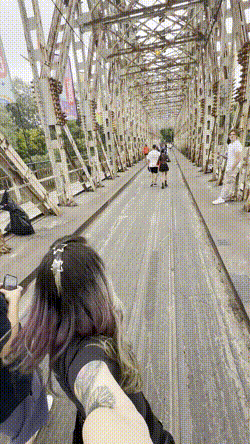

In [26]:
for highlight in filter_overlaps(highlights):
    with tempfile.NamedTemporaryFile(delete=False, suffix='.gif') as temp_file:
        ffmpeg.input(video_path).output(temp_file.name, ss=highlight[0], to=highlight[1], vf="fps=10,scale=250:-1", loglevel="quiet").run(overwrite_output=True)
        print(highlight)
        display(Image(temp_file.name))